In [1]:
'''
Notebook to generate graphs for player skill over time at different puzzles
'''

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

tqdm().pandas()

In [2]:
attempts=pd.read_csv('/w/225/1/chess/tactics/glicko_user_tactics_problem.csv_00')

In [3]:
#Filter for users that have only played at least x games
#attempts=attempts.loc[attempts.userGamesPlayed.between(2500,4000)]
attempts = attempts.loc[attempts.userGamesPlayed > 2500]

In [4]:
puzzle_data = pd.read_csv('/w/225/1/chess/tactics/tactics_problem.csv')
attempts = pd.merge(attempts,puzzle_data[['tactics_problem_id','rating']],on='tactics_problem_id',how='inner')

In [5]:
#Create rating labels for the problems
puzzle_start = 800
puzzle_end = 2400
interval = 100
puzzle_ratings = np.arange(puzzle_start,puzzle_end,interval)
#puzzle_data['problem_rating_labels'] = pd.cut(puzzle_data['rating'],np.arange(puzzle_start,puzzle_end,interval),labels=range(1,((puzzle_end-puzzle_start)//interval)))
#attempts = pd.merge(attempts,puzzle_data[['tactics_problem_id','problem_rating_labels']],on='tactics_problem_id',how='inner')
attempts['problem_rating_labels'] = pd.cut(attempts['rating'],puzzle_ratings,labels=range(1,((puzzle_end-puzzle_start)//interval)))

In [6]:
#attempts.drop('rating_labels',axis=1,inplace=True)
#attempts = attempts[attempts.problem_rating_labels.isna() == False]
attempts.shape

(24940819, 17)

In [7]:
#Create rating labels for the players
player_start = 1500
player_end = 2500
player_ratings = np.arange(player_start,player_end,interval)
attempts['player_rating_labels'] = pd.cut(attempts['ratingUser'],player_ratings,labels=range(1,((player_end-player_start)//interval)))

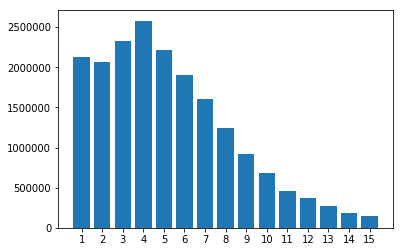

In [10]:
import matplotlib.pyplot as plt
counts = attempts.groupby(['problem_rating_labels'])['is_passed'].count()
plt.bar(counts.index,counts.values)
plt.xticks(counts.index)
plt.show()

In [11]:
sum(counts)/attempts.shape[0]

0.7660913220211413

In [12]:
#attempts.drop('rating_labels',axis=1,inplace=True)
#attempts = attempts[attempts.player_rating_labels.isna() == False]
#attempts.shape
puzzle_ratings

array([ 800,  900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800,
       1900, 2000, 2100, 2200, 2300])

In [13]:
trimmed_data = attempts[['seconds','is_passed','player_rating_labels','problem_rating_labels']]

In [14]:
print(trimmed_data.shape)
trimmed_data = trimmed_data[trimmed_data.problem_rating_labels.isna() == False]
print(trimmed_data.shape)
trimmed_data = trimmed_data[trimmed_data.player_rating_labels.isna() == False]
print(trimmed_data.shape)

(24940819, 4)
(19106945, 4)
(18259968, 4)


In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

def plot_graph(data,rating):
    figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    colors = sns.color_palette("hls", len(data))
    for index,data in enumerate(probs):
        color = colors[index]
        #Calculate standard error 
        stderror = np.sqrt(np.var(data)/len(data))
        plt.plot(data,color=color,label=str(puzzle_ratings[index]))
        #Add 1.96 times the standard error to get the 95% confidence interval 
        plt.fill_between(time_range,data-(1.96*stderror),data+(1.96*stderror),alpha=0.4,color=color)
        
    plt.ylabel('Probability of success')
    plt.xlabel('Time waited >= x')
    plt.title('Success at puzzles for players around {}'.format(rating))
    plt.legend(loc=2)
    plt.savefig('../plots/timeplots/puzzle_time_success_{}_players.png'.format(rating))
    plt.clf()

In [16]:
time_range = list(range(0,40))
player_labels = list(range(1,((player_end-player_start)//interval)))
puzzle_labels = list(range(1,((puzzle_end-puzzle_start)//interval)))
# if A = # of correct attempts and B = # of problems where seconds >= x time and ratings for user and problem are 
#within a certain range. Want to find: P(A|B) = P(A&B)/P(B)
for player_label in tqdm(player_labels):
    probs = []
    print('Generating plot for players around: ' + str(player_ratings[player_label-1]))
    for prob_label in puzzle_labels:
        print('Doing ratings for puzzles around: ' + str(puzzle_ratings[prob_label-1]))
        rating_probs = []
        #Get problems that have both the correct problem rating label and player rating label
        rating_trimmed = trimmed_data.loc[(trimmed_data.problem_rating_labels == prob_label) & 
                                             (trimmed_data.player_rating_labels == player_label)]
        print('Num of attempts: ' + str(len(rating_trimmed)))
        #Filter the problemd from rating_trimmed that were attempted after at least time seconds
        for time in time_range:
            b_condition = rating_trimmed.loc[rating_trimmed.seconds >= time]
            rating_probs.append(len(b_condition.loc[b_condition.is_passed == 1])/len(b_condition))
        probs.append(rating_probs)
    #Making plot
    plot_graph(probs,player_ratings[player_label-1])

Generating plot for players around: 1500
Doing ratings for puzzles around: 800
Num of attempts: 30375
Doing ratings for puzzles around: 900
Num of attempts: 12854
Doing ratings for puzzles around: 1000
Num of attempts: 7209
Doing ratings for puzzles around: 1100
Num of attempts: 3241
Doing ratings for puzzles around: 1200
Num of attempts: 1273
Doing ratings for puzzles around: 1300
Num of attempts: 668
Doing ratings for puzzles around: 1400
Num of attempts: 370
Doing ratings for puzzles around: 1500
Num of attempts: 245
Doing ratings for puzzles around: 1600
Num of attempts: 109
Doing ratings for puzzles around: 1700
Num of attempts: 181
Doing ratings for puzzles around: 1800
Num of attempts: 130
Doing ratings for puzzles around: 1900
Num of attempts: 195
Doing ratings for puzzles around: 2000
Num of attempts: 166
Doing ratings for puzzles around: 2100
Num of attempts: 93
Doing ratings for puzzles around: 2200
Num of attempts: 139
Generating plot for players around: 1600
Doing ratings 

Doing ratings for puzzles around: 1500
Num of attempts: 86108
Doing ratings for puzzles around: 1600
Num of attempts: 93084
Doing ratings for puzzles around: 1700
Num of attempts: 95196
Doing ratings for puzzles around: 1800
Num of attempts: 83267
Doing ratings for puzzles around: 1900
Num of attempts: 78631
Doing ratings for puzzles around: 2000
Num of attempts: 61141
Doing ratings for puzzles around: 2100
Num of attempts: 42320
Doing ratings for puzzles around: 2200
Num of attempts: 31292



<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>